# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.datasets import CIFAR10
import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F

from helpers.dataset import ContrastiveCIFAR10
from helpers.config import TrainingConfig
from models.loss import NTXent, DCL, VICReg

# Load data

In [36]:
train_cfg = TrainingConfig(device=torch.device("mps"))

ds_train = ContrastiveCIFAR10("../data/cifar10/", train=True, download=True)
dl_train = DataLoader(ds_train, batch_size=train_cfg.batch_size, shuffle=True, num_workers=train_cfg.num_workers)

ds_test = CIFAR10("../data/cifar10/", train=False)

print(train_cfg, end="\n\n")
print(ds_train, end="\n\n")
print(ds_test)

Files already downloaded and verified
TrainingConfig(device=device(type='mps'), batch_size=16, num_workers=10, learning_rate=0.002, weight_decay=1e-06, max_epoch=1000)

Dataset ContrastiveCIFAR10
    Number of datapoints: 50000
    Root location: ../data/cifar10/
    Split: Train
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
                 RandomResizedCrop(size=(32, 32), scale=(0.3, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BICUBIC, antialias=True)
                 RandomHorizontalFlip(p=0.5)
                 RandomApply(    ColorJitter(brightness=(0.6, 1.4), contrast=(0.9, 1.1), hue=(-0.1, 0.1)))
                 RandomGrayscale(p=0.1)
                 ToDtype(scale=True)
                 Normalize(mean=[0.5], std=[0.5], inplace=False)
           )

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data/cifar10/
    Split: Test


torch.Size([3, 32, 32])


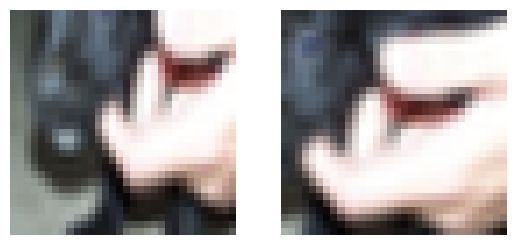

In [45]:
def imshow(*imgs):
    _, axes = plt.subplots(1, len(imgs))
    
    for i, img in enumerate(imgs):
        img = img / 2 + 0.5  # unnormalize
        axes[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
        axes[i].set_axis_off()
    
    plt.show()

idx = np.random.choice(range(len(ds_train)))
x_1, x_2 = ds_train[idx]

print(x_1.shape)
imshow(x_1, x_2)

# Model architecture

## Losses

In [14]:
z_1, z_2 = torch.rand((train_cfg.batch_size, 128)), torch.rand((train_cfg.batch_size, 128))

print(z_1.size())
print(z_2.size())

torch.Size([16, 128])
torch.Size([16, 128])


In [45]:
batch_size, emb_dim = z_1.size()

# minimize representations difference between two views of the same sample
representation_loss = F.mse_loss(z_1, z_2)  # ()

# stack along a new axis to benefit from batched operations
z = torch.concat((z_1, z_2), dim=0)  # (2 * bs, dim_emb)
z = z - torch.mean(z, dim=0)

# force std of each dimension to be closer to gamma (> 0) to avoid mapping samples to the same embedding vector
std_z = torch.std(z, dim=1)  # (1, dim_emb)
variance_loss = torch.mean(F.relu(1.0 - std_z))  # ()

# minimize covariance along embedding dimensions to decorrelate embedding dimensions
# in order to prevent them to from encoding the same information

covariance_z = (z.T @ z).fill_diagonal_(0.0) / (batch_size - 1)  # (dim_emb, dim_emb)
covariance_loss = torch.sum(torch.square_(covariance_z)) / emb_dim  # ()



In [75]:
z = torch.stack((z_1, z_2), dim=0)
z -= z.mean(dim=1, keepdim=True)

assert torch.allclose(z[0], z_1 - z_1.mean(dim=0))
assert torch.allclose(z[1], z_2 - z_2.mean(dim=0))

In [83]:
z_std = torch.std(z, dim=1, keepdim=True)

assert torch.allclose(z_std[0], (z_1 - z_1.mean(dim=0)).std(dim=0))
assert torch.allclose(z_std[1], (z_2 - z_2.mean(dim=0)).std(dim=0))

variance_loss = torch.mean(F.relu(1.0 - z_std))

In [135]:
print(z.size())

covariance = (z.permute(0, 2, 1) @ z) / (batch_size - 1)
print(covariance.size())
covariance.diagonal(dim1=1, dim2=2).zero_()
covariance_loss = torch.sum(covariance.pow_(2)) / emb_dim


NameError: name 'z' is not defined

In [15]:
loss = NTXent()
loss(z_1, z_2)

tensor(3.4304)

In [16]:
loss = DCL()
loss(z_1, z_2)

tensor(3.5736)

In [17]:
loss = VICReg()
loss(z_1, z_2)

tensor(22.0481)

## Encoder

In [46]:
from models.encoder import ResNet
from models.ssl import SSLModel

encoder = ResNet(
    in_channels=3,
    num_stage=3,
    num_block_per_stage=2,
)

dim_embedding = 64 * 2**(3-1)
model = SSLModel(encoder, dim_embedding=dim_embedding, num_hidden_proj=2)

print(f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,d} learnable params")
print(f"{sum(p.numel() for p in model.parameters()):,d} total params")
print(model)

3,441,216 learnable params
3,441,216 total params
SSLModel(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (residual_blocks): Sequential(
      (0): ResidualBlock(
        (_layers): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (shortcut): Identity()
      )
      (1): ResidualBlock(
        (_layers): Sequential(
          (0): Conv2d(64, 64, kernel_siz

In [122]:
#x1, _ = ds_train[0]

#z_1 = resnet(x1[None, ...])
#z_1.size()

In [141]:
loss_func = VICReg()

x1, x2 = next(iter(dl_train))
z1, z2 = model(x1), model(x2)

loss_func(z1, z2)

torch.Size([16, 512])
torch.Size([16, 512])


tensor(32.7293, grad_fn=<AddBackward0>)

In [19]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from models.loss import NTXent, DCL, VICReg

device = torch.device("mps")
max_epoch = 1

model.to(device)
model.train()

optimizer = AdamW(model.parameters(), lr=10 * train_cfg.learning_rate, weight_decay=train_cfg.weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=len(dl_train) * max_epoch, eta_min=train_cfg.learning_rate, verbose=False)
loss_func = VICReg(normalize=True)
#loss_func = DCL()
#loss_func = NTXent()

for epoch in range(max_epoch):
    running_loss = 0.0
    
    for step, (x_1, x_2) in enumerate(dl_train):
        optimizer.zero_grad(set_to_none=True)

        x_1, x_2 = x_1.to(device, non_blocking=True), x_2.to(device, non_blocking=True)
        z_1, z_2 = model(x_1, x_2)

        loss = loss_func(z_1, z_2)
        loss.backward()

        optimizer.step()
        scheduler.step()
        
        running_loss += loss.detach()
        
        print(f"Epoch {epoch + 1} - step {step + 1}/{len(dl_train)} - lr: {scheduler.get_last_lr()[-1]:.4f} - loss: {running_loss / (step + 1):.4f}", end="\r")
    
    print()

Epoch 1 - step 3125/3125 - lr: 0.0020 - loss: 23.8730


In [26]:
params = [(n, p) for (n, p) in model.named_parameters() if p.requires_grad and "bias" not in n]

Text(0, 0.5, 'gradient norm')

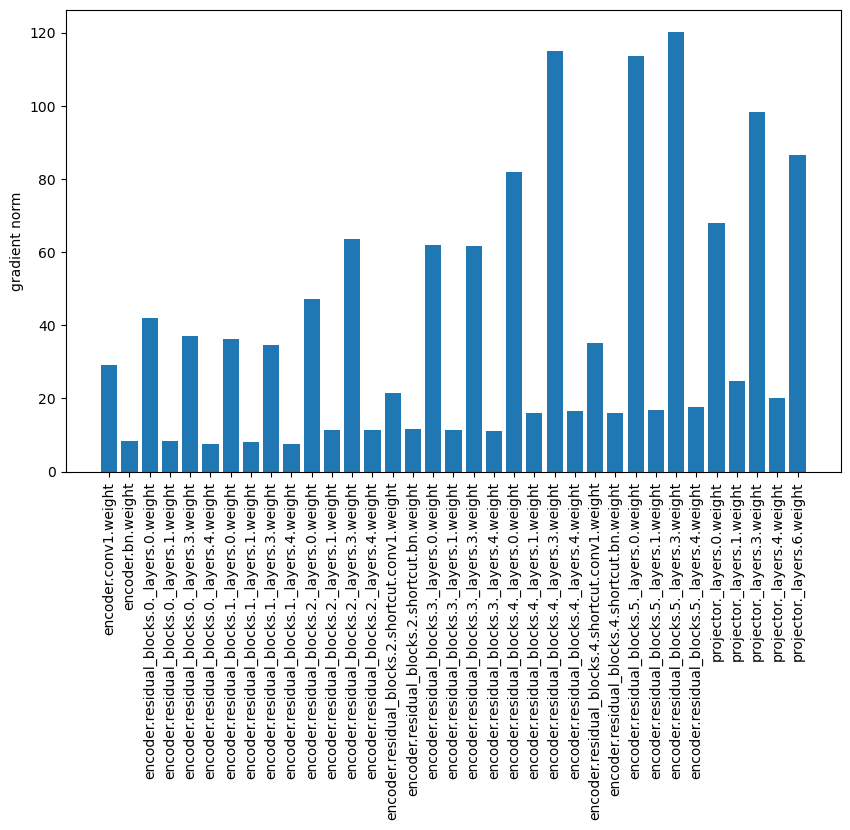

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

names, norms = zip(*[(n, p.detach().cpu().norm()) for (n, p) in params])
ax.bar(x=names, height=norms)
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel("gradient norm")

Text(0, 0.5, 'gradient abs mean')

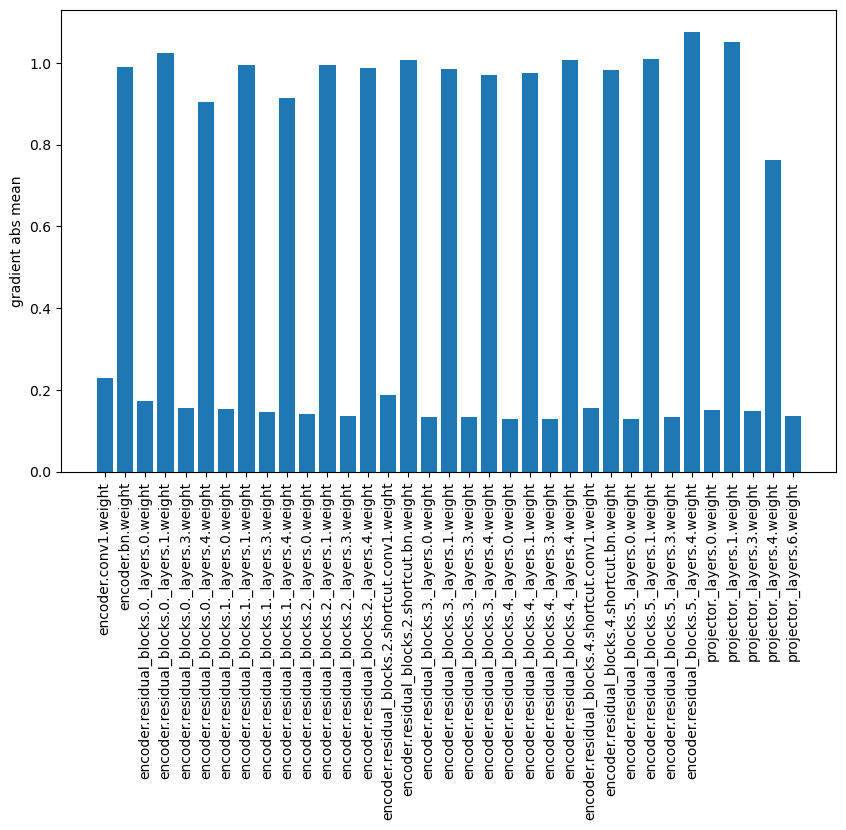

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))

names, mean = zip(*[(n, p.detach().cpu().abs().mean()) for (n, p) in params])
ax.bar(x=names, height=mean)
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel("gradient abs mean")

In [32]:
model.get_embeddings(x_1[None, ...].to(device))

tensor([[0.4357, 1.0465, 1.9586, 1.3537, 1.8027, 1.4756, 0.9437, 1.0413, 0.3258,
         1.4150, 0.3257, 0.5576, 0.4875, 1.8488, 1.1410, 1.1946, 1.7487, 1.5105,
         1.9316, 0.8997, 1.7297, 1.1914, 1.8262, 1.0434, 2.1628, 1.7960, 0.7147,
         1.4464, 1.5893, 1.3695, 0.4525, 0.8001, 0.9903, 1.5841, 1.4615, 0.8330,
         0.8202, 0.3190, 1.2563, 1.8276, 1.1832, 1.3347, 1.7226, 0.4497, 0.6888,
         0.3870, 2.0912, 0.6587, 1.3415, 0.6679, 0.6665, 1.7806, 1.3508, 1.8181,
         1.1498, 0.6025, 1.4468, 1.0619, 0.4829, 1.5304, 1.6014, 1.3518, 1.4298,
         1.1004, 0.4554, 1.3352, 1.0312, 1.5230, 0.1848, 1.7073, 0.9117, 0.4554,
         0.9961, 1.6310, 1.7150, 2.3698, 1.4606, 1.2120, 0.2897, 0.9096, 1.2421,
         1.5364, 0.5962, 0.6461, 1.4299, 1.0720, 1.8513, 0.9433, 1.3383, 1.2749,
         1.6361, 1.5284, 1.5069, 0.9397, 0.3779, 1.2017, 0.5161, 1.7663, 1.2732,
         2.2655, 1.5604, 0.5790, 0.3918, 0.3058, 1.5846, 0.3774, 1.6878, 0.8813,
         1.4882, 1.0725, 0.6